# Определение перспективного тарифа для телеком-компании

**Описание проекта**: \
Мы - аналитики компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов** : 

*Тариф "Смарт"*:
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
  - Минута разговора: 3 рубля
  - Сообщение: 3 рубля
  - 1 Гб интернет-трафика: 200 рублей

*Тариф "Ультра"*:
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
  - Минута разговора: 1 рубль
  - Сообщение: 1 рубль
  - 1 Гб интернет-трафика: 150 рублей

## Изучение данных

**Описание данных**:

Таблица **users** (информация о пользователях): \
`user_id` — уникальный идентификатор пользователя \
`first_name` — имя пользователя \
`last_name` — фамилия пользователя \
`age` — возраст пользователя (годы) \
`reg_date` — дата подключения тарифа (день, месяц, год) \
`churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных) \
`city` — город проживания пользователя \
`tariff` — название тарифного плана

Таблица **calls** (информация о звонках): \
`id` — уникальный номер звонка \
`call_date` — дата звонка \
`duration` — длительность звонка в минутах \
`user_id` — идентификатор пользователя, сделавшего звонок

Таблица **messages** (информация о сообщениях): \
`id` — уникальный номер сообщения \
`message_date` — дата сообщения \
`user_id` — идентификатор пользователя, отправившего сообщение

Таблица **internet** (информация об интернет-сессиях): \
`id` — уникальный номер сессии \
`mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах) \
`session_date` — дата интернет-сессии \
`user_id` — идентификатор пользователя

Таблица **tariffs** (информация о тарифах): \
`tariff_name` — название тарифа \
`rub_monthly_fee` — ежемесячная абонентская плата в рублях \
`minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату \
`messages_included` — количество сообщений в месяц, включённых в абонентскую плату \
`mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах) \
`rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата) \
`rub_per_message` — стоимость отправки сообщения сверх тарифного пакета \
`rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats as st

In [2]:
#прочитаем все таблицы и сохраним их в отдельные переменные
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

Посмотрим на каждую из таблиц по-очереди. Методами head, tail, sample, info и describe проведем первичный анализ данных.

Таблица **users**

In [3]:
display(users.head(),users.tail(),users.sample(5),users.describe(),users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
499,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
42,1042,42,NaN,Хабаровск,Константин,Добрынин,2018-11-25,smart
296,1296,60,NaN,Москва,Альфред,Черный,2018-06-05,smart
56,1056,73,2018-10-14,Иркутск,Радислав,Артемьев,2018-04-13,smart
201,1201,32,2018-12-03,Москва,Геннадий,Веселов,2018-08-06,ultra
307,1307,53,NaN,Самара,Симона,Авсейкина,2018-05-04,smart


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


None

In [4]:
len(list(users['user_id'].unique()))

500

У нас 500 уникальных пользователей

Вывода после предварительного осмотра: 
- столбцы `churn_date` и `reg_date` имеют неправильный тип данных (object)
- пропуски только в столбце `churn_date`, но они имеют обоснованность (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

Таблица **calls**

In [5]:
display(calls.head(),calls.tail(),calls.sample(5),calls.describe(),calls.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,id,call_date,duration,user_id
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499
202606,1499_219,2018-12-14,19.62,1499


,id,call_date,duration,user_id
41966,1102_393,2018-12-01,4.05,1102
124626,1321_76,2018-11-16,13.89,1321
19253,1052_402,2018-10-13,8.99,1052
81665,1203_238,2018-10-23,0.00,1203
50226,1124_445,2018-10-04,5.18,1124


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


None

Выводы после предварительного осмотра: 
- столбец `call_date`имеют неправильный тип данных (object)
- пропусков в данных нет

Таблица **messages**

In [6]:
display(messages.head(),messages.tail(),messages.sample(5),messages.describe(),messages.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,id,message_date,user_id
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499
123035,1499_183,2018-11-16,1499


,id,message_date,user_id
22247,1093_129,2018-06-30,1093
90910,1375_710,2018-04-20,1375
118437,1481_208,2018-12-30,1481
78538,1330_564,2018-02-10,1330
86107,1356_1124,2018-09-27,1356


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


None

Выводы после предварительного осмотра: 
- столбец `message_date`имеет неправильный тип данных (object)
- пропусков в данных нет

Таблица  **internet**

In [7]:
display(internet.head(),internet.tail(),internet.sample(5),internet.describe(),internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,Unnamed: 0,id,mb_used,session_date,user_id
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499
149395,149395,1499_156,544.37,2018-10-26,1499


,Unnamed: 0,id,mb_used,session_date,user_id
130594,130594,1435_202,113.20,2018-03-02,1435
128162,128162,1429_320,351.63,2018-05-17,1429
62344,62344,1211_177,896.02,2018-09-23,1211
140590,140590,1472_264,578.99,2018-03-23,1472
44545,44545,1154_103,483.37,2018-12-27,1154


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


None

Выводы после предварительного осмотра: 
- столбец `session_date`имеет неправильный тип данных (object)
- пропусков в данных нет
- появился столбец `Unnamed: 0`, который просто дублирует индексы. Удалим его сразу

In [8]:
del internet['Unnamed: 0']

In [9]:
#проверим удаление 
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Посмотрим на гистограмму распределения объема интернет сессий

<AxesSubplot:>

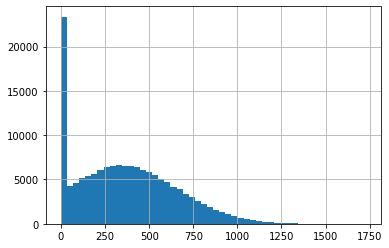

In [10]:
internet['mb_used'].hist(bins=50)

Аномалий не вижу. Большинство интернет сессий - короткие. Пользователи могли зайти посмотреть погоду/отправить сообщение в мессенджере. Далее распределение имеет форму нормального

Таблица **tariffs**

In [11]:
display(tariffs.head(),tariffs.tail(),tariffs.describe(),tariffs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


None

Выводы после предварительного осмотра: 
- на первый взгляд ,кажется, что всё хорошо

**Вывод**: Мы предварительно осмотрели данные, определили некоторые проблемы. Сейчас данные нужно предобработатать. Дополнительно с выявленными проблемами проверим данные на дубликаты, аномалии.

## Предобработка данных

Таблица **users**

In [12]:
#изменим тип данных
users['churn_date'] = pd.to_datetime(users['churn_date'], format="%Y-%m-%d")
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d")

Проверим стона столбец `city`, где могут быть неявные дубликаты. Cоздадим отдельный список городов, отсортируем по названию и посмотрим на него

In [13]:
unique_city = list(users['city'].unique())
unique_city.sort()
unique_city

['Архангельск',
 'Астрахань',
 'Балашиха',
 'Барнаул',
 'Белгород',
 'Брянск',
 'Владивосток',
 'Владикавказ',
 'Владимир',
 'Волгоград',
 'Волжский',
 'Вологда',
 'Воронеж',
 'Грозный',
 'Екатеринбург',
 'Иваново',
 'Ижевск',
 'Иркутск',
 'Казань',
 'Калининград',
 'Калуга',
 'Кемерово',
 'Киров',
 'Кострома',
 'Краснодар',
 'Красноярск',
 'Курган',
 'Курск',
 'Липецк',
 'Магнитогорск',
 'Махачкала',
 'Москва',
 'Мурманск',
 'Набережные Челны',
 'Нижневартовск',
 'Нижний Новгород',
 'Нижний Тагил',
 'Новокузнецк',
 'Новороссийск',
 'Новосибирск',
 'Омск',
 'Оренбург',
 'Орёл',
 'Пенза',
 'Пермь',
 'Петрозаводск',
 'Подольск',
 'Ростов-на-Дону',
 'Рязань',
 'Самара',
 'Санкт-Петербург',
 'Саранск',
 'Саратов',
 'Севастополь',
 'Смоленск',
 'Сочи',
 'Ставрополь',
 'Стерлитамак',
 'Сургут',
 'Тамбов',
 'Тверь',
 'Тольятти',
 'Томск',
 'Тула',
 'Тюмень',
 'Улан-Удэ',
 'Ульяновск',
 'Уфа',
 'Хабаровск',
 'Химки',
 'Чебоксары',
 'Челябинск',
 'Череповец',
 'Чита',
 'Якутск',
 'Ярославль']

Кажется, всё хорошо. Тогда просто проверим всю таблицу на дубликаты

In [14]:
users.duplicated().sum()

0

Идем дальше \
Таблица **calls** \
Поменяем неправильный тип данных и проверим таблицу на дубликаты. Так же округлим значение до минут (в верхнюю сторону). Так как Мегалайн округляет секунды до минут 

In [15]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")

In [16]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')

In [17]:
calls.duplicated().sum()

0

In [18]:
# df

Идем дальше \
Таблица **messages** \
Поменяем неправильный тип данных и проверим таблицу на дубликаты

In [19]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")

In [20]:
messages.duplicated().sum()

0

Далее таблица **internet** \
Аналогично - меняет тип данных и проверяем на дубликаты 

In [21]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")

In [22]:
internet.duplicated().sum()

0

Последняя таблица - **tariffs** \
При предварительном осмотре мы не нашли нареканий. \
Но есть столбец `tariff_name`, где возможно появление неочевидных дубликатов

In [23]:
tariffs['tariff_name'].unique()

array(['smart', 'ultra'], dtype=object)

Всё хорошо. Проверим на дубликаты

In [24]:
tariffs.duplicated().sum()

0

**Вывод**: Исправили недочеты ,выявленные на предварительном осмотре данных ,проверили на дубликаты. Теперь можно произвести необходимые расчеты

## Расчеты и добавление результатов в таблицу 

Для каждого пользователя проведём следующие расчеты: 

- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [25]:
#добавим столбец с названиями месяцев в таблицу calls
calls['month'] = calls['call_date'].dt.month
calls

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,1,1499,12
202603,1499_216,2018-10-18,19,1499,10
202604,1499_217,2018-11-10,11,1499,11
202605,1499_218,2018-10-06,5,1499,10


Далее создадим отдельную таблицу **user_call**, в которой:
- сгруппируем данные по каждому пользователю (`user_id`) и месяцам (`user_id`)
- посчитаем количество сделанных звонков (применим `count` к `id`)
- посчитаем израсходованные минуты по месяцам (применим sum к `duraction`)
- переименуем столбцы

In [26]:
user_calls = calls.groupby(['user_id', 'month'])\
                  .agg({'id':'count','duration':'sum'})\
                  .reset_index()\
                  .rename(columns={'id':'total_calls_by_month','duration':'duraction_by_month'})
user_calls.head()

,user_id,month,total_calls_by_month,duraction_by_month
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


### Количество отправленных сообщений по месяцам

In [27]:
#добавим столбец с названиями месяцев в таблицу messages
messages['month'] = messages['message_date'].dt.month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


Повторим действия, как в предыдущем шаге

In [28]:
user_messages = messages.groupby(['user_id', 'month'])\
                        .agg({'id':'count'})\
                        .reset_index()\
                        .rename(columns={'id':'total_messages_by_month'})
user_messages.head()

,user_id,month,total_messages_by_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


### Объем израсходованного интернет-трафика по месяцам

In [29]:
#добавим столбец с названиями месяцев в таблицу internet
internet['month'] = internet['session_date'].dt.month
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


Повторим действия , как в предыдущем шаге

In [30]:
user_internet = internet.groupby(['user_id', 'month'])\
                        .agg({'mb_used':'sum'})\
                        .reset_index()\
                        .rename(columns={'mb_used':'total_mb_by_month'})
user_internet.head()

,user_id,month,total_mb_by_month
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


### Помесячная выручка с каждого пользователя

Соединим 3 новых таблицы расчитанные выше

In [31]:
df = user_calls.merge(user_messages, on=['user_id','month'], how='outer')
df = df.merge(user_internet, on=['user_id','month'], how='outer')
df

,user_id,month,total_calls_by_month,duraction_by_month,total_messages_by_month,total_mb_by_month
0,1000,5,22.0,159.0,22.0,2253.49
1,1000,6,43.0,172.0,60.0,23233.77
2,1000,7,47.0,340.0,75.0,14003.64
3,1000,8,52.0,408.0,81.0,14055.93
4,1000,9,58.0,466.0,57.0,14568.91
...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17206.30
3210,1489,10,NaN,NaN,21.0,19559.44
3211,1489,11,NaN,NaN,20.0,17491.56
3212,1489,12,NaN,NaN,35.0,17322.51


Таким образом, мы получили данные по расходам на звонки, смс и интернет по каждому пользователю по месяцам. Теперь добавим так же остальную информацию по пользователям и информацию по тарифам в общую таблицу df

In [32]:
#добавим таблицу users
df = df.merge(users, on='user_id', how='outer')

In [33]:
#переименуем столбец tariff_name в таблице tariffs и добавим таблицу tariffs
tariffs = tariffs.rename(columns = {'tariff_name' : 'tariff'})
df = df.merge(tariffs, on='tariff', how='left')
df

,user_id,month,total_calls_by_month,duraction_by_month,total_messages_by_month,total_mb_by_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,22.0,159.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6.0,43.0,172.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7.0,47.0,340.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8.0,52.0,408.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9.0,58.0,466.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,NaN,21.0,19559.44,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3212,1489,11.0,NaN,NaN,20.0,17491.56,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3213,1489,12.0,NaN,NaN,35.0,17322.51,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3214,1128,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,3000,1950,150,1,1


In [34]:
#исправим тип данных после слияния таблиц 
df['month'] = pd.array(df['month'], dtype = pd.Int64Dtype())

Мы создали общую таблицу по всем пользователям со всеми имеющимися данными. Проверим её на пропуски и дубликаты

In [35]:
df.isna().sum()

user_id                       0
month                         2
total_calls_by_month         42
duraction_by_month           42
total_messages_by_month     499
total_mb_by_month            13
age                           0
churn_date                 3027
city                          0
first_name                    0
last_name                     0
reg_date                      0
tariff                        0
messages_included             0
mb_per_month_included         0
minutes_included              0
rub_monthly_fee               0
rub_per_gb                    0
rub_per_message               0
rub_per_minute                0
dtype: int64

Здесь Nan (кроме churn_date) - отсутствие звонков, смс или интернет трафика. Заменим пропуски в этих столбцах нулями.

In [36]:
df['total_calls_by_month'] = df['total_calls_by_month'].fillna(0)
df['duraction_by_month'] = df['duraction_by_month'].fillna(0)
df['total_messages_by_month'] = df['total_messages_by_month'].fillna(0)
df['total_mb_by_month'] = df['total_mb_by_month'].fillna(0)

In [37]:
df.duplicated().sum()

0

Теперь мы можем расчитать помесячную выручку с каждого пользователя

Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану

Объявим функцию, которая будет брать данные из строки и возвращать сумму сверхлимитных трат пользователя

In [38]:
def above_the_limit_tariff(row):
    sms = (row['total_messages_by_month'] - row['messages_included']) * row['rub_per_message']
    mins = (row['duraction_by_month'] - row['minutes_included']) * row['rub_per_minute']
    mbs = (np.ceil(row['total_mb_by_month'] - row['mb_per_month_included'])/1024) * row['rub_per_gb']
    total = 0
    for i in [sms, mins, mbs]:
        if i > 0:
            total += i
    return total

Добавим новый столбец в df, в котором будут содержаться значения функции above_the_limit_tariff

In [39]:
df['above_the_limit_tariff'] = df.apply(lambda x: above_the_limit_tariff(x), axis=1)

In [40]:
df

,user_id,month,total_calls_by_month,duraction_by_month,total_messages_by_month,total_mb_by_month,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,above_the_limit_tariff
0,1000,5,22.0,159.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.000000
1,1000,6,43.0,172.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.000000
2,1000,7,47.0,340.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.000000
3,1000,8,52.0,408.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.000000
4,1000,9,58.0,466.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,10,0.0,0.0,21.0,19559.44,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,820.312500
3212,1489,11,0.0,0.0,20.0,17491.56,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,416.406250
3213,1489,12,0.0,0.0,35.0,17322.51,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,383.398438
3214,1128,<NA>,0.0,0.0,0.0,0.00,51,2018-12-23,Волжский,Ксения,...,2018-12-15,ultra,1000,30720,3000,1950,150,1,1,0.000000


In [41]:
df['total_revenue'] = df['rub_monthly_fee'] + df['above_the_limit_tariff']

In [42]:
df.head()

,user_id,month,total_calls_by_month,duraction_by_month,total_messages_by_month,total_mb_by_month,age,churn_date,city,first_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,above_the_limit_tariff,total_revenue
0,1000,5,22.0,159.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
1,1000,6,43.0,172.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
2,1000,7,47.0,340.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
3,1000,8,52.0,408.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
4,1000,9,58.0,466.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0


**Вывод** : Отлично! Мы сделали расчеты, соединили все имеющиеся таблицы в одну общую и теперь может переходить к анализу данных

In [43]:
# check
df['total_revenue'].sum()

4774262.1328125

In [44]:
# check
df[df['duraction_by_month'] > 500 ][['user_id', 'month', 'duraction_by_month',
       'total_messages_by_month', 'total_mb_by_month', 
       'city', 'reg_date', 'tariff', 'total_revenue']].tail(4)

,user_id,month,duraction_by_month,total_messages_by_month,total_mb_by_month,city,reg_date,tariff,total_revenue
3163,1496,11,662.0,46.0,25063.40,Вологда,2018-01-27,smart,2931.312500
3164,1496,12,518.0,51.0,20736.15,Вологда,2018-01-27,smart,1657.195312
3167,1497,12,545.0,17.0,19918.60,Челябинск,2018-10-09,smart,1575.429688
3174,1499,11,612.0,59.0,17963.31,Пермь,2018-09-27,smart,1421.593750


## Анализ данных

Проанализируем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
- Посчитаем среднее количество, дисперсию и стандартное отклонение
- Построим гистограммы
- Опишем распределения

Посмотрим на **минуты разговора**. Создадим сводную таблицу

In [45]:
calls_by_tariffs =df.pivot_table( \
                                 index = ['tariff'], \
                                 values = ['duraction_by_month'], \
                                 aggfunc =  ['mean','var','std'])
calls_by_tariffs

,mean,var,std
,duraction_by_month,duraction_by_month,duraction_by_month
tariff,,,
smart,417.747534,36281.393836,190.476754
ultra,526.089249,101052.493549,317.887549


Посмотрим на гистограмму распределения времени звонков  для тарифа смарт

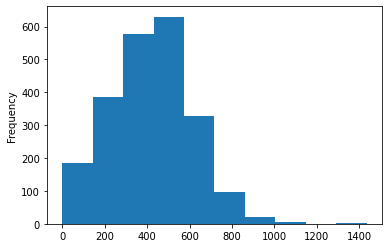

In [46]:
df[df['tariff'] == 'smart']['duraction_by_month'].plot(kind='hist', bins=10)
plt.show()

Распределение имеет форму нормального 

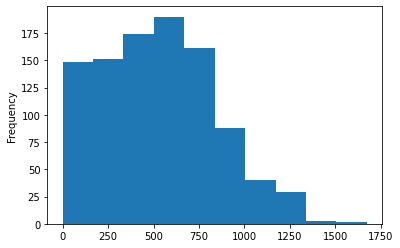

In [47]:
df[df['tariff'] == 'ultra']['duraction_by_month'].plot(kind='hist', bins=10)
plt.show()

На ultra пользлователи тратят в среднем около 536 минут, на smart - 417. Но дисперсия ( и соответственно среднее отклонение) на ultra выше

Разница ощутима. в 1.5-2 раза стандартное отклонение на тарифе ultra выше

Дисперсия так же будет многобольше на тарифе ultra,nак как это просто std^2

Посмотрим на **сообщения**. Повторим действия, которые мы делали для звонков

In [48]:
messages_by_tariffs =df.pivot_table( \
                                 index = ['tariff'], \
                                 values = ['total_messages_by_month'], \
                                 aggfunc =  ['mean','var','std'])
messages_by_tariffs

,mean,var,std
,total_messages_by_month,total_messages_by_month,total_messages_by_month
tariff,,,
smart,33.369058,796.955256,28.230396
ultra,49.313387,2285.417425,47.806040


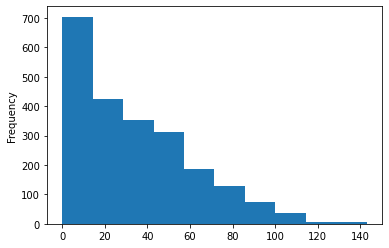

In [49]:
df[df['tariff'] == 'smart']['total_messages_by_month'].plot(kind='hist', bins=10)
plt.show()

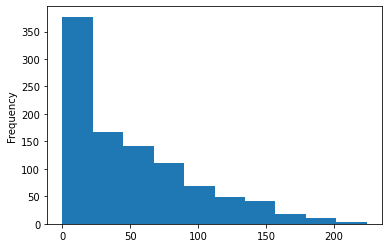

In [50]:
df[df['tariff'] == 'ultra']['total_messages_by_month'].plot(kind='hist', bins=10)
plt.show()

- Распределения данных - правосторонние
- В среднем сообщения на ultra отравляют больше
- Отметим, что смс не очень востребованы на обоих тарифах. Если пользователи smart тратят около половины, включенных в тариф смс, то на ultra из 1000 включенных, даже 100 не отправляют

Посмотрим на **интернет**

In [51]:
internet_by_tariffs =df.pivot_table( \
                                 index = ['tariff'], \
                                 values = ['total_mb_by_month'], \
                                 aggfunc =  ['mean','var','std'])
internet_by_tariffs

,mean,var,std
,total_mb_by_month,total_mb_by_month,total_mb_by_month
tariff,,,
smart,16201.118655,3.456484e+07,5879.187315
ultra,19449.059970,1.020321e+08,10101.095459


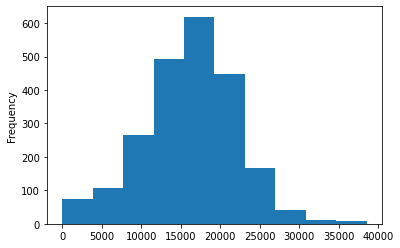

In [52]:
df[df['tariff'] == 'smart']['total_mb_by_month'].plot(kind='hist', bins=10)
plt.show()

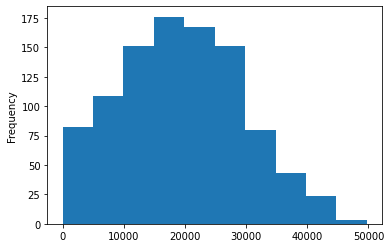

In [53]:
df[df['tariff'] == 'ultra']['total_mb_by_month'].plot(kind='hist', bins=10)
plt.show()

- Распредедение на smart - нормальное, ultra - близкое к нормальному с левосторонним уклоном 
- Интернетом на ultra пользуются так же больше, чем на smart
- Относительно включенного в тариф объма: на ultra пользователи укладываются в рамки, а вот на smart в среднем по месяцам значение превышает включенные 15Гб интернета

Так же std на ultra выше, чем на smart

**Выводы**: 
- Пользователи тарифа ultra чаще звонят, пишут смс и расходуют больше mb интернета, чем пользователи smart. 
- Относительно включенного объема услуг:
  - Звонки на smart расходуются рационально. На ultra же у пользователей остаётся большой остаток на конец месяца
  - СМС не очень нужны. На обоих тарифах остаётся остаток на конец месяца( на ultra - очень большой)
  - Интернет нужнее СМС. На ultra интернет расходуют рационально. На smart 15Гб - маловато для современных пользователей

## Проверка гипотез

Рассмотрим 2 гипотезы: 
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

### Гипотеза №1

Сформулируем 2 гипотезы (нулевую и альтернативную):
- H0 : Средние значения выручки пользователей тарифов "Ультра" и "Смарт" равны (не разлчаются)
- Н1 : Средние значения выручки пользователей тарифов "Ультра" и "Смарт различаются

У нас имеются **2 независимые** выборки. Будем использовать тест по t-критерию Стьюдента 

In [54]:
#введем 2 новых df по разным тарифам
ultra = df[df['tariff'] == 'ultra']
smart = df[df['tariff'] == 'smart']

In [55]:
#создадим 2 переменные по выручкам по каждом тарифу
ultra_total_revenue = ultra['total_revenue']
smart_total_revenue = smart['total_revenue']

In [56]:
#установим значем alpha = 5%
alpha = .05

In [57]:
#и проведём стат.тест
results_1 = st.ttest_ind(ultra_total_revenue, smart_total_revenue ,equal_var = False)

Значение equal_var = False мы указали, так как в предыдущих шагах выяснили, что дисперсии наших выборок не равны между собой

Теперь сравним результаты теста с указанным нами alpha и сделаем выводы

In [58]:
display('p-значение:',results_1.pvalue)

if (results_1.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

'p-значение:'

7.412520935402694e-299

Отвергаем нулевую гипотезу


**Вывод**: p-значение страмиться к 0. Если бы в тесте, мы указали значение *equal_var = True*, то получили бы значение *2.089871859317439e-213*. А при *equal_var = False*, pvalue близко к 0. Мы можем смело отвергнуть нулевую гипотезу и сделать вывод:**Средние значения выручки пользователей тарифов "Ультра" и "Смарт различаются**

### Гипотеза №2

Сформулируем 2 гипотезы (нулевую и альтернативную):

- H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
- H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Здесь так же имеются **2 независимые** выборки. Будем использовать тест по t-критерию Стьюдента 

Для начала посмотрим на города, представленные в нашей таблице 

In [59]:
df['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Курган', 'Барнаул', 'Красноярск', 'Архангельск', 'Липецк',
       'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Волжский', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

Раделим нашу общую df на 2 отдельные таблицы( пользователи из Москвы и остальные пользователи)

In [60]:
moscow_clients = df.query('city == "Москва"')
other_cities_clients = df.query(('city != "Москва"'))

Введем 2 переменные по выручкам этих пользователем 

In [61]:
moscow_clients_total_revenue = moscow_clients['total_revenue']
other_cities_clients_total_revenue = other_cities_clients['total_revenue']

Значениe aplha оставим тем же и проведём тест

In [62]:
results_2 = st.ttest_ind(moscow_clients_total_revenue, other_cities_clients_total_revenue)

Здесь значение equal_var оставим по умолчанию True. Так как дисперсию этих выборок мы не сравнивали, но есть основания полагать что здесь уже пользователи с тарифами smart и ultra смешались между собой

In [63]:
display('p-значение:',results_2.pvalue)

if (results_2.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

'p-значение:'

0.4668031150367593

Не получилось отвергнуть нулевую гипотезу


**Вывод**: Значимых различий нет 

## Общий вывод

**Выводы**:
- Пользователи на ultra и smart по-разному тратят ресурсы тарифа. Это логично, у всех разные запросы на звонки, смс и интернет. В этом и суть разных тарифов
- Звонки нужны. Но количество минут стоит, включенных в ultra, стоит пересмотреть
- СМС не нужны. Пользователи на smart тратят в среднем около половины своих смс. На ultra снова остаётся очень большой запас. Некоторые пользователи вообще не пишут смс( не пользуются данным видом услуг)
- Интернет нужнее всего. На ultra интернет тратится рационально, на smart же пользователи постоянно заходят в доп.оплату
- Статистической разницы между выручками по пользователям из Москвы и остальных городов нет


**Рекомендаци**:
- Самое очевидное: необходимо рассмотреть введение нового тарифа ( или даже нескольких) с пакетами звонков, смс и интернета между тарифами smart и ultra. Не хватает промежуточных значений между 500 и 3000 минут, 50 и 1000 смс, 15ГБ и 30 ГБ интернета
- Или провести ребалансировку ultra по звонкам и смс, а smart по интернету 
- Или дать возможность пользователям конвертировать по собственному желанию( например, ненужные смс в нужный интернет) 